In [1]:
import math
from sklearn.datasets import make_moons, make_circles, make_classification

def generate_data(dataset_type, n_samples=1000, noise=0.1):
    if dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
        # normalize
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    elif dataset_type == 'classification':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2,
                                   n_redundant=0, n_clusters_per_class=1)
    elif dataset_type == '5gaussians':
        centers = [[math.cos(2 * math.pi * i / 5), math.sin(2 * math.pi * i / 5)] for i in range(5)]
        X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2,
                                   n_redundant=0, n_clusters_per_class=1, n_classes=5,
                                   class_sep=2.0, centers=centers)
    else:
        raise ValueError("Unknown dataset type")
    return X, y

In [2]:
import torch 
from cfm.modules import SimpleFlowModel
from cfm.utils import Trainer
X0 = torch.randn(10000, 2) - 0.3
X1, _ = generate_data('moons', n_samples=10000, noise=0.05)
X1 = torch.from_numpy(X1).float()
X1[:, 0] = X1[:, 0] * 2.0 + 4
X1[:, 1] = X1[:, 1] * 2.5 - 1
dataset = torch.utils.data.TensorDataset(X0, X1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

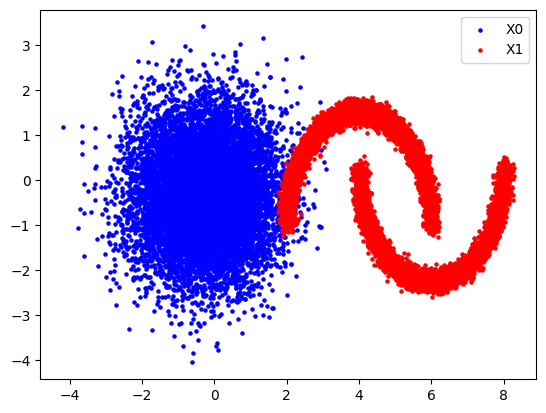

In [3]:
# visualize the data
import matplotlib.pyplot as plt
plt.scatter(X0[:, 0], X0[:, 1], s=5, color='blue', label='X0')
plt.scatter(X1[:, 0], X1[:, 1], s=5, color='red', label='X1')

plt.legend()
plt.show()

In [ ]:
# Uncomment the following code to train the flow model and save the checkpoint. You can adjust the hyperparameters as needed.

# flow_model = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=32)

# optimizer = torch.optim.Adam(flow_model.parameters(), lr=1e-3)
# trainer = Trainer(flow_model, dataloader, n_epochs=2000, sigma=0.005, sample_from_coupling=None, optimizer=optimizer)
# trainer.train(from_random_gaussian=False)

# torch.save(flow_model.state_dict(), 'checkpoints/flow_model.pth')

In [4]:
from cfm.utils import FlowModelPipeline

model = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=32)
pipeline = FlowModelPipeline.from_pretrained(model, state_dict_path='checkpoints/flow_model.pth', device='cuda')

seeds = torch.randn(1000, 2) - 0.3
targets = X1
samples = pipeline.sample(seeds, n_steps=100)

In [6]:
animation_dir = 'assets/flow_animation_frames.mp4'

pipeline.generate_animation(
    seeds, xlim=(-5, 10), ylim=(-5, 5), n_steps=100,
    dataset_from=seeds[:500], dataset_to=targets[:500],
    save_path=animation_dir
)

/Data/yiming.chen/APM588OT/OT_CFM/cfm/utils/pipeline.py:134: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.92, bottom=0.08)


In [8]:
from cfm.utils import mp4_to_frames, crop_frames

frames_dir = 'assets/flow_animation_frames'
out_dir = 'assets/flow_animation_cropped_frames'

mp4_to_frames(video_path=animation_dir, out_dir=frames_dir, fps=3)
crop_frames(frames_dir, out_dir, threshold=250, pad_ratio=0.05)